# Timeseries Forecasting

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

In [2]:
import os

fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np

temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

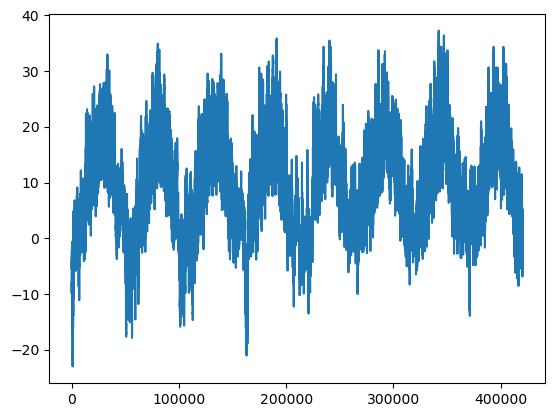

In [4]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)), temperature)

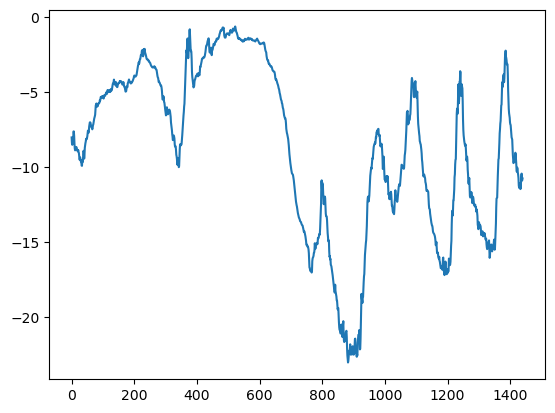

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
from tensorflow import keras

sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


2025-06-26 12:18:13.216875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-06-26 12:18:13.218528: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Baseline (MAE)

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.0
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


: 

## Dense

In [ ]:
import keras
from keras import layers
import keras.callbacks

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mae", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)
model = keras.models.load_model("jena_dense.keras")

Epoch 1/10
819/819 [==============================] - 13s 16ms/step - loss: 2.7443 - mae: 2.7443 - val_loss: 2.5804 - val_mae: 2.5804
Epoch 2/10
819/819 [==============================] - 13s 16ms/step - loss: 2.3215 - mae: 2.3215 - val_loss: 2.5440 - val_mae: 2.5440
Epoch 3/10
819/819 [==============================] - 13s 16ms/step - loss: 2.2121 - mae: 2.2121 - val_loss: 2.5475 - val_mae: 2.5475
Epoch 4/10
819/819 [==============================] - 13s 16ms/step - loss: 2.1409 - mae: 2.1409 - val_loss: 2.6945 - val_mae: 2.6945
Epoch 5/10
819/819 [==============================] - 12s 15ms/step - loss: 2.0909 - mae: 2.0909 - val_loss: 2.6983 - val_mae: 2.6983
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 2.0529 - mae: 2.0529 - val_loss: 2.6358 - val_mae: 2.6358
Epoch 7/10
819/819 [==============================] - 12s 15ms/step - loss: 2.0247 - mae: 2.0247 - val_loss: 2.6599 - val_mae: 2.6599
Epoch 8/10
810/819 [============================>.] - ETA: 0s 

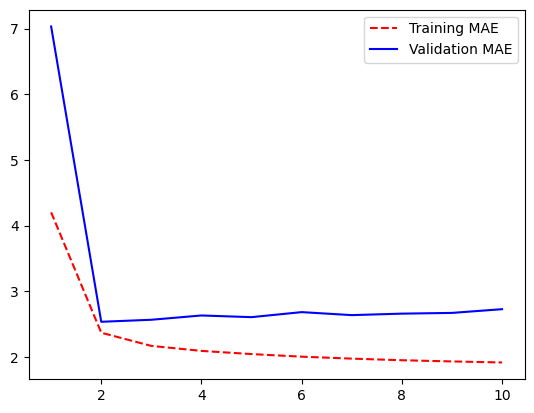

In [ ]:
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.legend()
plt.show()

## Conv1D

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 18s 21ms/step - loss: 22.6766 - mae: 3.6858 - val_loss: 17.2399 - val_mae: 3.2162
Epoch 2/10
819/819 [==============================] - 17s 21ms/step - loss: 14.3458 - mae: 2.9954 - val_loss: 14.6278 - val_mae: 3.0361
Epoch 3/10
819/819 [==============================] - 18s 22ms/step - loss: 13.0757 - mae: 2.8526 - val_loss: 14.5759 - val_mae: 3.0207
Epoch 4/10
819/819 [==============================] - 18s 22ms/step - loss: 12.2463 - mae: 2.7574 - val_loss: 14.0923 - val_mae: 2.9665
Epoch 5/10
819/819 [==============================] - 20s 24ms/step - loss: 11.6316 - mae: 2.6838 - val_loss: 13.9462 - val_mae: 2.9654
Epoch 6/10
819/819 [==============================] - 19s 23ms/step - loss: 11.0732 - mae: 2.6175 - val_loss: 14.1828 - val_mae: 2.9931
Epoch 7/10
819/819 [==============================] - 18s 22ms/step - loss: 10.6320 - mae: 2.5641 - val_loss: 14.7935 - val_mae: 3.0567
Epoch 8/10
819/819 [============================

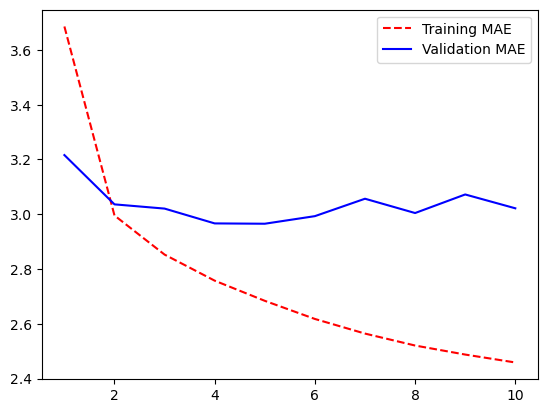

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.legend()

## LSTM

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks,
)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

NameError: name 'keras' is not defined

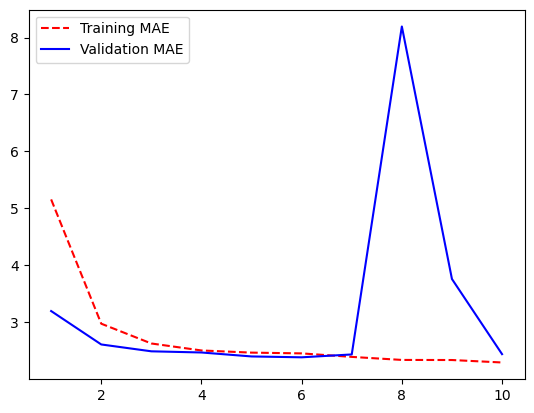

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r--", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.legend()